In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

In [2]:
import copy, math

In [3]:
import plotly.express as px

In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [5]:
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#import plotly.graph_objects as go
init_notebook_mode(connected=True)

# Setup

## Define all keys

In [6]:
state_key = {
'EC':'Eastern Cape',
'FS':'Free State',
'GP':'Gauteng',
'KZN':'Kwazulu Natal',
'LP':'Limpopo',
'MP':'Mpumalanga',
'NC':'Northern Cape',
'NW':'North-West',
'WC':'Western Cape'
}
state_filter = list(state_key.keys())
state_filter

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

In [7]:
state_labels = list(state_key.values())

In [8]:
state_filter_i = copy.deepcopy(state_filter)
state_filter_i.append('Date')
state_filter_i

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC', 'Date']

In [9]:
state_filter

['EC', 'FS', 'GP', 'KZN', 'LP', 'MP', 'NC', 'NW', 'WC']

## Download SA population stats

In [10]:
# Mid-year 2019 Estimates
# https://www.statssa.gov.za/publications/P0302/P03022019.pdf
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/za_province_pop.csv'
province_pops = pd.read_csv(url, header=None, names=['Province','Pop'])
province_pops

,Province,Pop
0,Gauteng,15176115
1,KwaZulu-Natal,11289086
2,Western Cape,6844272
3,Eastern Cape,6712276
4,Limpopo,5982584
5,Mpumalanga,4592187
6,Northwest,4027160
7,Free State,2887465
8,Northern Cape,1263875


In [11]:
country_pop = province_pops['Pop'].sum()
country_pop

58775020

In [12]:
province_pops.iloc[0]['Pop']

15176115

## Download case data

In [13]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv'
states_all_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=0)
states_all_i.tail()

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-07-20,20200720,65316.0,10727.0,136879.0,45614.0,5156.0,7424.0,2351.0,14337.0,85772.0,52.0,373628,https://twitter.com/nicd_sa/status/12853467780...
2020-07-21,20200721,66759.0,11352.0,139435.0,47685.0,5355.0,7664.0,2539.0,14634.0,86329.0,46.0,381798,https://twitter.com/nicd_sa/status/12856772968...
2020-07-22,20200722,67818.0,12332.0,144582.0,50521.0,5712.0,8286.0,2727.0,15073.0,87847.0,50.0,394948,https://twitter.com/nicd_sa/status/12860532628...
2020-07-23,20200723,69445.0,13443.0,148854.0,53406.0,6068.0,8987.0,2970.0,15901.0,88928.0,50.0,408052,https://twitter.com/nicd_sa/status/12863909561...
2020-07-24,20200724,71338.0,14542.0,153020.0,57162.0,6394.0,9756.0,3175.0,16548.0,90011.0,50.0,421996,https://twitter.com/nicd_sa/status/12867360173...


In [14]:
states_all = states_all_i.copy()
states_all = states_all.reset_index()
states_all = states_all.rename(columns={'date':'Date'})
states_all.tail()

,Date,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
135,2020-07-20,20200720,65316.0,10727.0,136879.0,45614.0,5156.0,7424.0,2351.0,14337.0,85772.0,52.0,373628,https://twitter.com/nicd_sa/status/12853467780...
136,2020-07-21,20200721,66759.0,11352.0,139435.0,47685.0,5355.0,7664.0,2539.0,14634.0,86329.0,46.0,381798,https://twitter.com/nicd_sa/status/12856772968...
137,2020-07-22,20200722,67818.0,12332.0,144582.0,50521.0,5712.0,8286.0,2727.0,15073.0,87847.0,50.0,394948,https://twitter.com/nicd_sa/status/12860532628...
138,2020-07-23,20200723,69445.0,13443.0,148854.0,53406.0,6068.0,8987.0,2970.0,15901.0,88928.0,50.0,408052,https://twitter.com/nicd_sa/status/12863909561...
139,2020-07-24,20200724,71338.0,14542.0,153020.0,57162.0,6394.0,9756.0,3175.0,16548.0,90011.0,50.0,421996,https://twitter.com/nicd_sa/status/12867360173...


# Analysis per province

In [15]:
state_plot = states_all[state_filter_i]
state_plot

,EC,FS,GP,KZN,LP,MP,NC,NW,WC,Date
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-03-05
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2020-03-07
2,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,2020-03-08
3,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,2020-03-09
4,0.0,0.0,5.0,7.0,0.0,0.0,0.0,0.0,1.0,2020-03-11
...,...,...,...,...,...,...,...,...,...,...
135,65316.0,10727.0,136879.0,45614.0,5156.0,7424.0,2351.0,14337.0,85772.0,2020-07-20
136,66759.0,11352.0,139435.0,47685.0,5355.0,7664.0,2539.0,14634.0,86329.0,2020-07-21
137,67818.0,12332.0,144582.0,50521.0,5712.0,8286.0,2727.0,15073.0,87847.0,2020-07-22
138,69445.0,13443.0,148854.0,53406.0,6068.0,8987.0,2970.0,15901.0,88928.0,2020-07-23


In [16]:
state_plotly = state_plot.melt(id_vars='Date', var_name='Province', value_name='Cases')
state_plotly

,Date,Province,Cases
0,2020-03-05,EC,0.0
1,2020-03-07,EC,0.0
2,2020-03-08,EC,0.0
3,2020-03-09,EC,0.0
4,2020-03-11,EC,0.0
...,...,...,...
1255,2020-07-20,WC,85772.0
1256,2020-07-21,WC,86329.0
1257,2020-07-22,WC,87847.0
1258,2020-07-23,WC,88928.0


In [17]:
#https://plotly.com/python/discrete-color/#color-sequences-in-plotly-express
colour_series = px.colors.qualitative.Vivid
colour_series

['rgb(229, 134, 6)',
 'rgb(93, 105, 177)',
 'rgb(82, 188, 163)',
 'rgb(153, 201, 69)',
 'rgb(204, 97, 176)',
 'rgb(36, 121, 108)',
 'rgb(218, 165, 27)',
 'rgb(47, 138, 196)',
 'rgb(118, 78, 159)',
 'rgb(237, 100, 90)',
 'rgb(165, 170, 153)']

In [18]:
fig = px.bar(state_plotly, title='Total Cases Per Province', x='Date', y='Cases', color='Province',
             barmode='relative', color_discrete_sequence=colour_series)
fig.update_traces(hovertemplate=None)
fig.update_layout(hovermode="x")
fig.show()

# Daily analysis for country

In [19]:
states_all['Actual Data'] = states_all['total'].diff()

In [20]:
smoothed = states_all['Actual Data'].rolling(7,
    win_type='gaussian',
    min_periods=1,
    center=True).mean(std=2).round()

idx_start = np.searchsorted(smoothed, 25)

smoothed = smoothed.iloc[idx_start:]
states_all['Smoothed Data'] = smoothed

In [21]:
daily = states_all[['Date','Actual Data','Smoothed Data']]

In [22]:
daily_plotly = daily.melt(id_vars='Date', var_name='Range', value_name='Daily Cases')

In [23]:
fig_daily_increase = px.line(daily_plotly, title='Daily Case Increase for South Africa',
        x='Date', y='Daily Cases', color='Range', line_shape='spline')
fig_daily_increase.update_traces(hovertemplate=None)
fig_daily_increase.update_layout(hovermode="x")
fig_daily_increase.show()

# Combined analysis

## Download death data

In [24]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv'
states_all_deaths = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_all_deaths.tail()

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-07-20,20200720,871,57,999,429,33,52,15,48,2669,0,5173,https://twitter.com/nicd_sa/status/12853467780...
2020-07-21,20200721,945,57,1042,459,33,52,15,48,2717,0,5368,https://twitter.com/nicd_sa/status/12856772968...
2020-07-22,20200722,1345,62,1156,477,33,52,15,48,2752,0,5940,https://twitter.com/nicd_sa/status/12860532628...
2020-07-23,20200723,1393,62,1187,515,33,52,23,48,2780,0,6093,https://twitter.com/nicd_sa/status/12863909561...
2020-07-24,20200724,1406,63,1326,565,33,52,23,48,2827,0,6343,https://twitter.com/nicd_sa/status/12867360173...


## Download recovery data

In [25]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv'
states_all_recover = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True,index_col=0).sort_index()
states_all_recover.tail()

,YYYYMMDD,EC,FS,GP,KZN,LP,MP,NC,NW,WC,UNKNOWN,total,source
date,,,,,,,,,,,,,
2020-07-20,20200720,44807,1128,58512,13494,2144,2159,970,3241,68410,0,194865,https://twitter.com/nicd_sa/status/12853467780...
2020-07-21,20200721,47263,1272,66434,13920,2518,2348,1087,3241,70061,0,208144,https://twitter.com/nicd_sa/status/12856772968...
2020-07-22,20200722,49938,1315,77397,18067,2518,3435,1100,3914,71491,0,229175,https://twitter.com/nicd_sa/status/12860532628...
2020-07-23,20200723,53591,1821,77397,18786,2781,4018,1152,4019,72695,0,236260,https://twitter.com/nicd_sa/status/12863909561...
2020-07-24,20200724,55692,1873,82126,18786,3022,4403,1177,4795,73897,0,245771,https://twitter.com/nicd_sa/status/12867360173...


## Download testing data
Only for country

In [26]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_timeline_testing.csv'
states_all_tests = pd.read_csv(url, parse_dates=['date'], dayfirst=True, index_col=0)
states_all_tests.tail()

,YYYYMMDD,cumulative_tests,recovered,hospitalisation,critical_icu,ventilation,deaths,contacts_identified,contacts_traced,scanned_travellers,passengers_elevated_temperature,covid_suspected_criteria,source
date,,,,,,,,,,,,,
2020-07-20,20200720,2505646.0,194865,NaN,NaN,NaN,5173,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/20/update-...
2020-07-21,20200721,2536921.0,208144,NaN,NaN,NaN,5368,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/21/update-...
2020-07-22,20200722,2585474.0,229175,NaN,NaN,NaN,5940,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/22/update-...
2020-07-23,20200723,2632106.0,236260,NaN,NaN,NaN,6093,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/23/update-...
2020-07-24,20200724,2684488.0,245771,NaN,NaN,NaN,6343,NaN,NaN,NaN,NaN,NaN,https://sacoronavirus.co.za/2020/07/24/update-...


In [27]:
casezero = states_all_i.index[0]
caselast = states_all_i.index[-1]
casezero, caselast

(Timestamp('2020-03-05 00:00:00'), Timestamp('2020-07-24 00:00:00'))

In [28]:
tests_series = states_all_tests.loc[casezero:caselast]['cumulative_tests']
tests_series

date
2020-03-06        200.0
2020-03-07        241.0
2020-03-11        645.0
2020-03-12        848.0
2020-03-13        924.0
                ...    
2020-07-20    2505646.0
2020-07-21    2536921.0
2020-07-22    2585474.0
2020-07-23    2632106.0
2020-07-24    2684488.0
Name: cumulative_tests, Length: 138, dtype: float64

## Combine all data

In [29]:
cases_series = pd.Series(states_all_i['total'].values, index=states_all_i.index.values, name='Cases')
cases_series

2020-03-05         1
2020-03-07         2
2020-03-08         3
2020-03-09         7
2020-03-11        13
               ...  
2020-07-20    373628
2020-07-21    381798
2020-07-22    394948
2020-07-23    408052
2020-07-24    421996
Name: Cases, Length: 140, dtype: int64

In [30]:
deaths_series = pd.Series(states_all_deaths['total'].values, index=states_all_deaths.index, name='Deaths')
recover_series = pd.Series(states_all_recover['total'].values, index=states_all_recover.index, name='Recovered')

In [31]:
states_combine = pd.concat([cases_series, recover_series, deaths_series, tests_series], axis=1)
states_combine

,Cases,Recovered,Deaths,cumulative_tests
2020-03-05,1.0,NaN,NaN,NaN
2020-03-06,NaN,NaN,NaN,200.0
2020-03-07,2.0,NaN,NaN,241.0
2020-03-08,3.0,NaN,NaN,NaN
2020-03-09,7.0,NaN,NaN,NaN
...,...,...,...,...
2020-07-20,373628.0,194865.0,5173.0,2505646.0
2020-07-21,381798.0,208144.0,5368.0,2536921.0
2020-07-22,394948.0,229175.0,5940.0,2585474.0
2020-07-23,408052.0,236260.0,6093.0,2632106.0


In [32]:
states_combine = states_combine.rename(columns={'cumulative_tests':'Tests'})

In [33]:
# Assume previous day testing result for missing data point
states_combine.loc[casezero,'Tests'] = 163

In [34]:
#idx = pd.date_range(casezero, caselast)
# Reindex complete date range
#filled_model = combined_model.reindex(idx, method='ffill')

In [35]:
states_master = states_combine.ffill(axis=0)

In [36]:
states_changed = states_master[['Recovered','Deaths']].sum(axis=1)

In [37]:
active_all = states_master['Cases'].sub(states_changed)
active_all

2020-03-05         1.0
2020-03-06         1.0
2020-03-07         2.0
2020-03-08         3.0
2020-03-09         7.0
                ...   
2020-07-20    173590.0
2020-07-21    168286.0
2020-07-22    159833.0
2020-07-23    165699.0
2020-07-24    169882.0
Length: 141, dtype: float64

In [38]:
states_master['Active'] = active_all

In [39]:
states_master

,Cases,Recovered,Deaths,Tests,Active
2020-03-05,1.0,NaN,NaN,163.0,1.0
2020-03-06,1.0,NaN,NaN,200.0,1.0
2020-03-07,2.0,NaN,NaN,241.0,2.0
2020-03-08,3.0,NaN,NaN,241.0,3.0
2020-03-09,7.0,NaN,NaN,241.0,7.0
...,...,...,...,...,...
2020-07-20,373628.0,194865.0,5173.0,2505646.0,173590.0
2020-07-21,381798.0,208144.0,5368.0,2536921.0,168286.0
2020-07-22,394948.0,229175.0,5940.0,2585474.0,159833.0
2020-07-23,408052.0,236260.0,6093.0,2632106.0,165699.0


In [40]:
states_wide = states_master.reset_index()
states_wide = states_wide.rename(columns={'index':'Date'})
states_wide

,Date,Cases,Recovered,Deaths,Tests,Active
0,2020-03-05,1.0,NaN,NaN,163.0,1.0
1,2020-03-06,1.0,NaN,NaN,200.0,1.0
2,2020-03-07,2.0,NaN,NaN,241.0,2.0
3,2020-03-08,3.0,NaN,NaN,241.0,3.0
4,2020-03-09,7.0,NaN,NaN,241.0,7.0
...,...,...,...,...,...,...
136,2020-07-20,373628.0,194865.0,5173.0,2505646.0,173590.0
137,2020-07-21,381798.0,208144.0,5368.0,2536921.0,168286.0
138,2020-07-22,394948.0,229175.0,5940.0,2585474.0,159833.0
139,2020-07-23,408052.0,236260.0,6093.0,2632106.0,165699.0


In [41]:
state_wide_plotly = states_wide.melt(id_vars='Date', var_name='Data', value_name='Count')
state_wide_plotly

,Date,Data,Count
0,2020-03-05,Cases,1.0
1,2020-03-06,Cases,1.0
2,2020-03-07,Cases,2.0
3,2020-03-08,Cases,3.0
4,2020-03-09,Cases,7.0
...,...,...,...
700,2020-07-20,Active,173590.0
701,2020-07-21,Active,168286.0
702,2020-07-22,Active,159833.0
703,2020-07-23,Active,165699.0


## Plot combined data

In [42]:
px_data_sa = px.line(state_wide_plotly, x='Date', y='Count', color='Data', line_shape='spline')
fig_data_sa = make_subplots(specs=[[{"secondary_y": True}]])

In [109]:
fig_data_sa.add_trace(px_data_sa['data'][0], secondary_y=True)
fig_data_sa.add_trace(px_data_sa['data'][1], secondary_y=True)
fig_data_sa.add_trace(px_data_sa['data'][2], secondary_y=True)
fig_data_sa.add_trace(px_data_sa['data'][4], secondary_y=True)
fig_data_sa.add_trace(px_data_sa['data'][3], secondary_y=False)

fig_data_sa.update_yaxes(title_text="Rest of Data", secondary_y=True)
fig_data_sa.update_yaxes(title_text="Tests", secondary_y=False)
fig_data_sa.update_layout(title="Covid-19 Data for South Africa")

fig_data_sa.update_traces(hovertemplate=None)
fig_data_sa.update_layout(hovermode="x")

# Summmary Data

In [111]:
latestcases = states_wide.iloc[-1]
latestcases['Cases'], latestcases['Recovered'], latestcases['Deaths'], latestcases['Active'], latestcases['Tests']

(421996.0, 245771.0, 6343.0, 169882.0, 2684488.0)

In [113]:
latestcases['Date']

Timestamp('2020-07-24 00:00:00')

# Evaluate district data

In [45]:
districts_gp = {
'date':'date',
'Ekurhuleni\tCases':'Ekurhuleni',
'Johannesburg\tCases':'Johannesburg',
'Sedibeng\tCases':'Sedibeng',
'Tshwane\tCases':'Tshwane',
'West Rand\tCases':'West Rand',
'West Rand\tCases':'West Rand',
'GP Unallocated\tCases':'Unknown'
}
districts = districts_gp.keys()

In [46]:
file_name = 'provincial_' + 'gp' + '_cumulative.csv'  
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/district_data/' + file_name
states_district = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True).sort_index()

states_district_filter = states_district[districts]
col_tol = states_district_filter.sum(axis=1, numeric_only=True)
pd.options.mode.chained_assignment = None
states_district_filter['Total'] = col_tol

#states = states_filter_wp
states_district_filter.tail()

,date,Ekurhuleni\tCases,Johannesburg\tCases,Sedibeng\tCases,Tshwane\tCases,West Rand\tCases,GP Unallocated\tCases,Total
100,2020-07-20,30606.0,59374.0,8131.0,25021.0,9004.0,4743.0,136879.0
101,2020-07-21,31067.0,60424.0,8339.0,25642.0,9148.0,4815.0,139435.0
102,2020-07-22,32271.0,62320.0,8744.0,26866.0,9486.0,4895.0,144582.0
103,2021-07-23,33243.0,63760.0,9080.0,27905.0,9820.0,5046.0,148854.0
104,2022-07-24,34195.0,65104.0,9528.0,28980.0,10064.0,5149.0,153020.0


# Rt Model 1

## Data Import

In [47]:
#dsfsi
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
states_all_rt_i = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.35    0.79
          2020-04-12  3.35     5.13    1.25
          2020-04-13  3.12     4.54    1.56
          2020-04-14  2.72     3.88    1.41
          2020-04-15  2.27     3.29    1.12
...                    ...      ...     ...
Total RSA 2020-07-20  0.74     0.84    0.63
          2020-07-21  0.97     1.07    0.86
          2020-07-22  1.15     1.25    1.04
          2020-07-23  1.26     1.35    1.14
          2020-07-24  1.37     1.46    1.26

[852 rows x 3 columns]

In [48]:
states_all_rt = states_all_rt_i.copy()
states_all_rt = states_all_rt.reset_index()
states_all_rt = states_all_rt.rename(columns={'date':'Date'})
states_all_rt = states_all_rt.rename(columns={'ML':'Rt'})
states_all_rt = states_all_rt.rename(columns={'state':'Province'})
states_all_rt

,Province,Date,Rt,High_90,Low_90
0,EC,2020-04-11,3.84,6.35,0.79
1,EC,2020-04-12,3.35,5.13,1.25
2,EC,2020-04-13,3.12,4.54,1.56
3,EC,2020-04-14,2.72,3.88,1.41
4,EC,2020-04-15,2.27,3.29,1.12
...,...,...,...,...,...
847,Total RSA,2020-07-20,0.74,0.84,0.63
848,Total RSA,2020-07-21,0.97,1.07,0.86
849,Total RSA,2020-07-22,1.15,1.25,1.04
850,Total RSA,2020-07-23,1.26,1.35,1.14


## Setup Rt

In [49]:
#state_single = states_rt.filter(like='Total RSA', axis=0) # for index data
state_single = states_all_rt.query("Province == 'Total RSA'")
state_single

,Province,Date,Rt,High_90,Low_90
724,Total RSA,2020-03-19,2.11,3.70,0.22
725,Total RSA,2020-03-20,2.50,3.73,1.09
726,Total RSA,2020-03-21,2.75,3.71,1.67
727,Total RSA,2020-03-22,2.87,3.67,1.99
728,Total RSA,2020-03-23,2.97,3.64,2.20
...,...,...,...,...,...
847,Total RSA,2020-07-20,0.74,0.84,0.63
848,Total RSA,2020-07-21,0.97,1.07,0.86
849,Total RSA,2020-07-22,1.15,1.25,1.04
850,Total RSA,2020-07-23,1.26,1.35,1.14


In [123]:
X0rt1 = states_all_rt.iloc[1]['Date']
X0rt1

Timestamp('2020-04-12 00:00:00')

In [116]:
latest_result_rt = state_single.iloc[-1]
X2rt1 = latest_result_rt['Date']
latest_d_rt1 = X2rt1.strftime("%d %B %Y")
rt1 = latest_result_rt['Rt']
latest_d_rt1, rt1

('24 July 2020', 1.37)

## Latest Rt summary

In [117]:
rt1_last_df = states_all_rt_i.groupby(level=0)[['ML']].last()
rt1_last_df

,ML
state,
EC,0.94
FS,1.38
GP,1.20
KZN,1.40
LP,1.19
MP,1.69
NC,1.54
NW,1.49
Total RSA,1.37


In [118]:
rt1_states = rt1_last_df['ML'].to_dict()

## Country Rt

In [57]:
state_single["e_plus"] = state_single['High_90'].sub(state_single['Rt'])
state_single["e_minus"] = state_single['Rt'].sub(state_single['Low_90'])

In [115]:
fig_rt1 = px.line(state_single, x='Date', y='Rt',
              error_y='e_plus', error_y_minus='e_minus',
              title='Model 1: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt1.update_traces(hovertemplate=None)
fig_rt1.update_layout(hovermode="x")
fig_rt1['data'][0]['error_y']['color'] = 'lightblue'

fig_rt1.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt1.show()

## Province Rt

In [59]:
states_rt = states_all_rt.query("Province != 'Total RSA'")
states_rt

,Province,Date,Rt,High_90,Low_90
0,EC,2020-04-11,3.84,6.35,0.79
1,EC,2020-04-12,3.35,5.13,1.25
2,EC,2020-04-13,3.12,4.54,1.56
3,EC,2020-04-14,2.72,3.88,1.41
4,EC,2020-04-15,2.27,3.29,1.12
...,...,...,...,...,...
719,WC,2020-07-20,0.22,0.47,0.00
720,WC,2020-07-21,0.91,1.22,0.59
721,WC,2020-07-22,1.51,1.79,1.18
722,WC,2020-07-23,1.80,2.06,1.48


In [60]:
fig_px = px.line(states_rt, x='Date', y='Rt', color='Province')
fig_len = len(fig_px['data'])

In [61]:
fig_rt_province = make_subplots(rows=3, cols=3,
                    subplot_titles=state_labels,
                    shared_xaxes=True, shared_yaxes=True)

In [63]:
r = 0
for p in range(fig_len):
    c = (p % 3) + 1
    if (c == 1):
        r+=1
    fig_rt_province.add_trace(fig_px['data'][p], row=r, col=c)
    
    fig_rt_province.add_shape(
    type="line",
    xref="x{0}".format(p+1),
    yref="y{0}".format(p+1),
    x0=X0rt1,
    y0=1,
    x1=X2rt1,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
    ))

In [64]:
fig_rt_province.update_layout(title_text="Rt for Covid-19 in South African Provinces", height=700)
fig_rt_province.update_traces(hovertemplate=None)
fig_rt_province.update_layout(hovermode="x")

# Rt model 2

In [65]:
url = 'https://raw.githubusercontent.com/dsfsi/covid19za/master/data/calc/calculated_rt_sa_mcmc.csv'
state_rt_mcmc = pd.read_csv(url, parse_dates=['date'], dayfirst=True, squeeze=True)
state_rt_mcmc = state_rt_mcmc.rename(columns={'date':'Date'})
state_rt_mcmc = state_rt_mcmc.rename(columns={'Median':'Rt'})
state_rt_mcmc

,Date,Rt,High_80,Low_80,Infections,Adjusted_Postive
0,2020-02-26,1.913,2.154,1.636,161.264,0.000
1,2020-02-27,1.916,2.146,1.663,2.227,0.000
2,2020-02-28,1.907,2.154,1.676,31.585,0.000
3,2020-02-29,1.910,2.122,1.660,60.160,0.000
4,2020-03-01,1.901,2.132,1.681,66.739,0.000
...,...,...,...,...,...,...
144,2020-07-19,1.036,1.197,0.809,8334.349,9520.406
145,2020-07-20,1.040,1.232,0.832,8464.054,9626.703
146,2020-07-21,1.034,1.257,0.840,8603.466,9733.795
147,2020-07-22,1.035,1.264,0.837,8752.123,9842.723


In [66]:
X0rt2 = state_rt_mcmc.iloc[0,:]['Date']
X0rt2

Timestamp('2020-02-26 00:00:00')

In [67]:
latest_rt2 = state_rt_mcmc.iloc[-1]
rt2 = round(latest_rt2['Rt'], 2)
rt2

1.04

In [68]:
X2rt2 = latest_rt2['Date']
latest_d_rt2 = X2rt2.strftime("%d %B %Y")
X2rt2, latest_d_rt2

(Timestamp('2020-07-23 00:00:00'), '23 July 2020')

In [69]:
state_rt_mcmc["e_plus"] = state_rt_mcmc['High_80'].sub(state_rt_mcmc['Rt'])
state_rt_mcmc["e_minus"] = state_rt_mcmc['Rt'].sub(state_rt_mcmc['Low_80'])

In [70]:
fig_rt2 = px.line(state_rt_mcmc, x='Date', y='Rt',
              error_y='e_plus', error_y_minus='e_minus',
              title='Model 2: Rt for Covid-19 in South Africa', line_shape='spline')
fig_rt2.update_traces(hovertemplate=None)
fig_rt2.update_layout(hovermode="x")
fig_rt2['data'][0]['error_y']['color'] = 'lightblue'

fig_rt2.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0rt2,
    y0=1,
    x1=X2rt2,
    y1=1,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig_rt2.show()

# Forecasts models
## Herd immunity

Herd immunity – estimating the level required to halt the COVID-19 epidemics in affected countries

Ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7151357/

In [71]:
Pc = 1-(1/rt2)
Pc * 100

3.8461538461538547

In [72]:
immune = country_pop * Pc
immune

2260577.692307697

## Rt trends model

In [73]:
cases_df = cases_series.to_frame()
cases_df = cases_df.reset_index()
cases_df = cases_df.rename(columns={'index':'Date'})
cases_df

,Date,Cases
0,2020-03-05,1
1,2020-03-07,2
2,2020-03-08,3
3,2020-03-09,7
4,2020-03-11,13
...,...,...
135,2020-07-20,373628
136,2020-07-21,381798
137,2020-07-22,394948
138,2020-07-23,408052


In [74]:
from datetime import timedelta, date

In [75]:
f = 60

In [104]:
f2 = 30

In [76]:
diff = cases_df['Cases'].diff()

In [77]:
d = diff.values[-1]
d

13944.0

In [78]:
r_scenarios = [1.5, 1.4, 1.3, 1.25, 1.2, 1.15, 1.1, 1.075, 1.05, 1.025, 1.0, 0.975, 0.95, 0.925, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.25, 0.1]
if (rt2 not in r_scenarios):
    r_scenarios.append(rt2)
    r_scenarios.sort(reverse=True)
r_scenarios

[1.5,
 1.4,
 1.3,
 1.25,
 1.2,
 1.15,
 1.1,
 1.075,
 1.05,
 1.04,
 1.025,
 1.0,
 0.975,
 0.95,
 0.925,
 0.9,
 0.85,
 0.8,
 0.7,
 0.6,
 0.5,
 0.25,
 0.1]

In [79]:
future_projections = None

for r in r_scenarios:
    projection = cases_df.copy()
    lastd = cases_df['Date'].iloc[-1]
    lastc = cases_df['Cases'].iloc[-1]
    d = diff.values[-1]

    for i in range(f):
        lastd += timedelta(days=1)
        newc = lastc + (d * r)
        d = newc - lastc
        lastc = newc

        calc = pd.DataFrame([[lastd, lastc]], columns=['Date', 'Cases'])
        # TODO: consider concat opertion here for faster processing
        projection = projection.append(calc)
        
    projection['R'] = r
    
    if future_projections is None:
        future_projections = projection
    else:
        future_projections = pd.concat([future_projections, projection])

future_projections

,Date,Cases,R
0,2020-03-05,1.000000,1.5
1,2020-03-07,2.000000,1.5
2,2020-03-08,3.000000,1.5
3,2020-03-09,7.000000,1.5
4,2020-03-11,13.000000,1.5
...,...,...,...
0,2020-09-18,423545.333333,0.1
0,2020-09-19,423545.333333,0.1
0,2020-09-20,423545.333333,0.1
0,2020-09-21,423545.333333,0.1


In [80]:
current_forecast = future_projections.query(f"R == {rt2}")
current_forecast

,Date,Cases,R
0,2020-03-05,1.000000e+00,1.04
1,2020-03-07,2.000000e+00,1.04
2,2020-03-08,3.000000e+00,1.04
3,2020-03-09,7.000000e+00,1.04
4,2020-03-11,1.300000e+01,1.04
...,...,...,...
0,2020-09-18,3.319528e+06,1.04
0,2020-09-19,3.449931e+06,1.04
0,2020-09-20,3.585550e+06,1.04
0,2020-09-21,3.726594e+06,1.04


In [81]:
last_forecast = current_forecast.iloc[-1]
future_f = math.trunc(last_forecast['Cases'])
future_f

3873279

In [82]:
infected = future_f / country_pop * 100
f'{infected:.1f}%'

'6.6%'

In [106]:
Xdt = date.today()
X0f = current_forecast.iloc[0]['Date']
X1f = Xdt + timedelta(days=f2)
X2f = last_forecast['Date']

datetime.date(2020, 8, 24)

In [84]:
max_forecast = max(current_forecast['Cases']) * 1.05
max_country = country_pop * 1.1
max_future = min(max_forecast, max_country)
max_future

4066943.788976374

In [108]:
fig6 = px.line(current_forecast, x='Date', y='Cases',
               range_y=[0, max_future],
               title='Covid-19 Cases Forecast for Current Rt')
fig6.update_traces(hovertemplate=None)
fig6.update_layout(hovermode="x")

fig6.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_future,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig6.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=X0f,
    y0=immune,
    x1=X2f,
    y1=immune,
    opacity=0.6,
    line=dict(
        color="Crimson",
        width=2,
        dash='dash'
))

fig6.add_annotation(
            x=X1f,
            y=immune * 1.05,
            text="Herd Immunity",
            showarrow=False
)

fig6.show()

In [86]:
increasing_forecast = future_projections.query(f"R > 1")

In [87]:
fig7 = px.line(increasing_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_country],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is bigger than 1)')
fig7.update_layout(hovermode="x")
#fig7["layout"].pop("updatemenus") # to remove play controls

fig7.show()

In [88]:
linear_forecast = future_projections.query(f"R == 1")
max_linear = max(linear_forecast['Cases'])

In [89]:
fig8 = px.line(linear_forecast, x='Date', y='Cases',
               range_y=[0, max_linear],
               title='Covid-19 Cases Forecast for Increasing Cases (Rt is 1)')
fig8.update_traces(hovertemplate=None)
fig8.update_layout(hovermode="x")

fig8.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_linear,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig8.show()

In [90]:
decline_forecast = future_projections.query(f"R < 1")
max_decline = max(decline_forecast['Cases']) * 1.05

In [91]:
fig9 = px.line(decline_forecast, x='Date', y='Cases',
               animation_frame='R', height=600, range_y=[0, max_decline],
               title='Covid-19 Cases Forecast for Decreasing Cases (Rt is less than 1)')
fig9.update_traces(hovertemplate=None)
fig9.update_layout(hovermode="x")

fig9.add_shape(
    type="line",
    xref="x",
    yref="y",
    x0=Xdt,
    y0=0,
    x1=Xdt,
    y1=max_decline,
    opacity=0.6,
    line=dict(
        color="Black",
        width=2,
        dash='dashdot'
))

fig9.show()

# Matplotlib result
## Rt plots

In [92]:
repo = 'dsfsi'
url = 'https://raw.githubusercontent.com/' + repo + '/covid19za/master/data/calc/calculated_rt_sa_provincial_cumulative.csv'
# states_all_rt_i already calcualte, but should calc again
states_all_rt_i = pd.read_csv(url,
                     parse_dates=['date'], dayfirst=True,
                     squeeze=True, index_col=[0,1])
states_all_rt_i

ML  High_90  Low_90
state     date                             
EC        2020-04-11  3.84     6.35    0.79
          2020-04-12  3.35     5.13    1.25
          2020-04-13  3.12     4.54    1.56
          2020-04-14  2.72     3.88    1.41
          2020-04-15  2.27     3.29    1.12
...                    ...      ...     ...
Total RSA 2020-07-20  0.74     0.84    0.63
          2020-07-21  0.97     1.07    0.86
          2020-07-22  1.15     1.25    1.04
          2020-07-23  1.26     1.35    1.14
          2020-07-24  1.37     1.46    1.26

[852 rows x 3 columns]

In [93]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-06'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    #fig.set_facecolor('w')
    
    return ax

In [94]:
credit = 'Source: covid19trends.co.za - Data: DSFSI'

Text(0.5, 0.98, '$R_t$ for COVID-19 in South Africa')

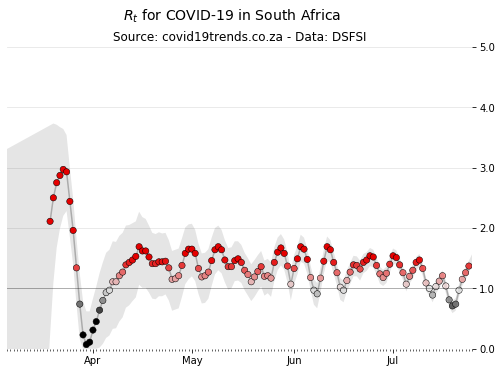

In [95]:
country = states_all_rt_i.filter(like='Total RSA', axis=0)
fig_country, ax = plt.subplots(figsize=(600/72,400/72))
ax = plot_rt(country, ax, state_name = '')
ax.set_title(credit, size=12, weight='light')
fig_country.suptitle(f'$R_t$ for COVID-19 in South Africa', size=14)

In [96]:
states_rt_i = states_all_rt_i.loc[state_filter]

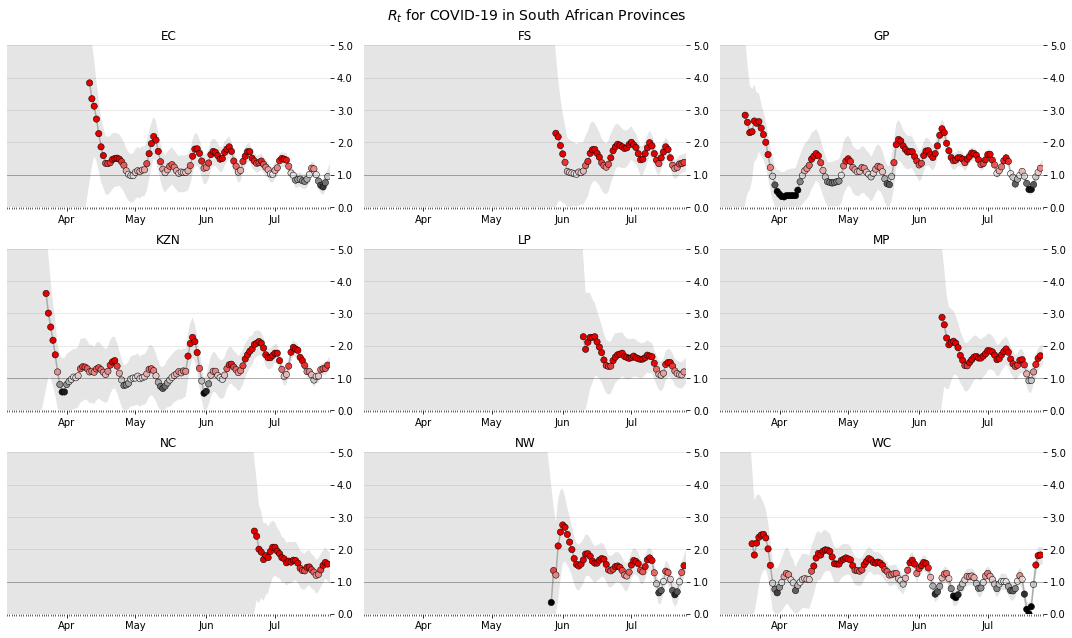

In [97]:
def all_plot(final_results):
    state_groups = final_results.groupby('state')
    
    ncols = 3
    nrows = int(np.ceil(len(state_groups) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

    for i, (state_name, result) in enumerate(state_groups):
        axes.flat[i] = plot_rt(result, axes.flat[i], state_name)

    fig.tight_layout()
    fig.set_facecolor('w')
    
    fig.suptitle(f'$R_t$ for COVID-19 in South African Provinces', size=14)
    fig.subplots_adjust(top=0.92)
    
all_plot(states_rt_i)

## Standings plots

In [98]:
# ZA: South Arica lockdown level data as of 2020/05/03
no_lockdown = [

]
partial_lockdown = [

]
# add items as required -> 'Western Cape','WC',

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [99]:
# ZA: df slighty different to US
mr = states_all_rt_i.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr

,ML,High_90,Low_90
state,,,
EC,0.94,1.16,0.68
FS,1.38,1.64,1.08
GP,1.20,1.36,1.04
KZN,1.40,1.57,1.20
LP,1.19,1.57,0.75
MP,1.69,1.99,1.33
NC,1.54,1.97,1.02
NW,1.49,1.81,1.14
Total RSA,1.37,1.46,1.26


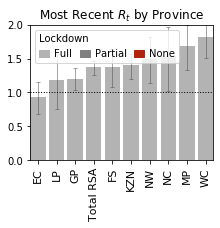

In [100]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Province'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

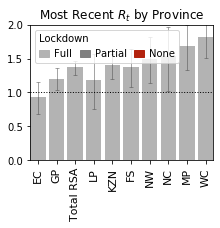

In [101]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

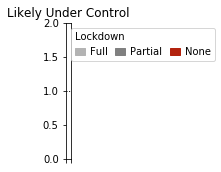

In [102]:
show = mr[mr.High_90.le(1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

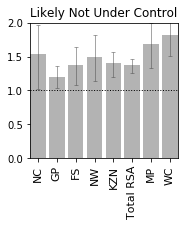

In [103]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Likely Not Under Control');
ax.get_legend().remove()